<h3 style="margin-bottom:0">Import Libraries</h4>

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from scipy import stats
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [2]:
def describe(df):
    desc = df.describe()
    desc.loc['n_unique', :] = df.nunique().values
    desc.loc['n_missing', :] = df.isna().sum().values
    return desc

In [3]:
def show_missingness(df):
    print("Missing rates")
    print('='*16)
    print(df.isna().sum() / len(df))
    print('='*16)

    msno.heatmap(df, figsize=(4,4))
    plt.show()

    msno.matrix(df, figsize=(4,4))
    plt.show()

<h3 style="margin-bottom:0">1) Data (5 pts)</h3>

In [4]:
data_dir = Path('../data')

In [5]:
df = pd.read_csv(data_dir / 'train.csv', low_memory=False, index_col='Id')
test_df = pd.read_csv(data_dir / 'test.csv', low_memory=False, index_col='Id')
odf = df.copy()
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data cleanup

In [6]:
def find_cols_with_missing(df):
    missing_counts = df.isna().sum()
    return missing_counts[missing_counts > 0].index.values.tolist()

We will fill missing values for categorical values according to the data description if possible.

In [7]:
def fill_missing_values_by_data_description(df):
    return (df
        .assign(Alley=lambda dataf: dataf['Alley'].fillna('NA'))
        .assign(MasVnrType=lambda dataf: dataf['MasVnrType'].fillna('None'))
        .assign(BsmtQual=lambda dataf: dataf['BsmtQual'].fillna('NA'))
        .assign(BsmtCond=lambda dataf: dataf['BsmtCond'].fillna('NA'))
        .assign(BsmtExposure=lambda dataf: dataf['BsmtExposure'].fillna('NA'))
        .assign(BsmtFinType1=lambda dataf: dataf['BsmtFinType1'].fillna('NA'))
        .assign(BsmtFinType2=lambda dataf: dataf['BsmtFinType2'].fillna('NA'))
        .assign(FireplaceQu=lambda dataf: dataf['FireplaceQu'].fillna('NA'))
        .assign(GarageType=lambda dataf: dataf['GarageType'].fillna('NA'))
        .assign(GarageFinish=lambda dataf: dataf['GarageFinish'].fillna('NA'))
        .assign(GarageQual=lambda dataf: dataf['GarageQual'].fillna('NA'))
        .assign(GarageCond=lambda dataf: dataf['GarageCond'].fillna('NA'))
        .assign(PoolQC=lambda dataf: dataf['PoolQC'].fillna('NA'))
        .assign(Fence=lambda dataf: dataf['Fence'].fillna('NA'))
        .assign(MiscFeature=lambda dataf: dataf['MiscFeature'].fillna('NA'))
    )

Missing rates
LotFrontage    0.177397
MasVnrArea     0.005479
Electrical     0.000685
GarageYrBlt    0.055479
dtype: float64


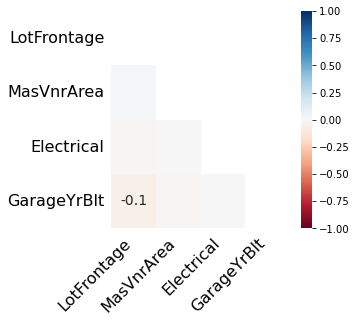

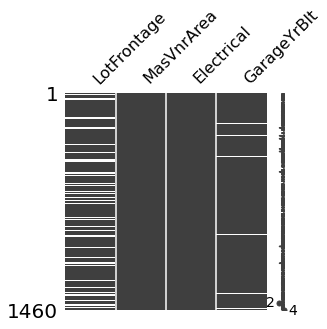

In [8]:
df = fill_missing_values_by_data_description(df)
cols_with_missing = find_cols_with_missing(df)
show_missingness(df[cols_with_missing])

There is a slight correlation between the missingness of `LotFrontage` and `GarageYrBlt`. However, we can assume that the missingness mechanism is MCAR, since the correlation is weak.

We'll impute the missing values with the mean value for numerical value and introduce a new category 
representing missing value for categorical variables.

In [9]:
def impute_with_new_category(df):
    return df.assign(Electrical=lambda dataf: dataf['Electrical'].fillna('#missing'))

In [10]:
df = impute_with_new_category(df)

## Feature selection

`Street` variable is a subset of `Alley` variable, hence, we can drop it without losing any information.

As we will predict the neighborhood of building, we don't need variables related to the sale of the property.

In [ ]:
df.hist(figsize=(32, 32));
plt.show();

In [12]:
def cleanup(df):
    return (df
        .pipe(fill_missing_values_by_data_description)
        .pipe(impute_with_new_category)
        .drop(columns=['Street', 'SaleCondition', 'SaleType', 'MoSold', 'YrSold', 'SalePrice'], errors='ignore')
    )


## Variable types

In [13]:
target_variable = 'Neighborhood'

In [14]:
df = cleanup(df)
x_train = df.drop(columns=[target_variable])

In [15]:
categs = sorted(x_train.select_dtypes('object').columns.tolist())
conts = sorted(x_train.select_dtypes('float').columns.tolist())
discretes = sorted(x_train.select_dtypes('int').columns.tolist())
numericals = conts + discretes

In [16]:
skewness = x_train[numericals].skew()
sym_numericals = skewness[skewness.abs() <= 0.5].index.tolist()
skewed_numericals = list(set(numericals).difference(sym_numericals))

In [18]:
def order_features(df):
    return df[numericals + categs]

col2idx = {col: i for i, col in enumerate(numericals + categs)}
numerical_col_indices = sorted([col2idx[col] for col in numericals])
categ_col_indices = sorted([col2idx[col] for col in categs])
sym_col_indices = sorted([col2idx[col] for col in sym_numericals])
skewed_col_indices = sorted([col2idx[col] for col in skewed_numericals])

In [27]:
def prepare_dataset(df):
    df = cleanup(df)
    x = order_features(df.drop(columns=[target_variable]))
    y = df[target_variable]
    x[categs] = x[categs].astype('category')
    if y.dtype == np.dtype('O'):
        y = y.astype('category')
    return x, y

## Training

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

def make_preprocessor():
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        (
            'scaler', 
             ColumnTransformer([
                ('scaler_sym', StandardScaler(), sym_col_indices),
                ('scaler_skewed', MinMaxScaler(), skewed_col_indices),
             ])
        ),
        ('pca', PCA())
    ])

    categorical_transformer = Pipeline([
        ('feat_selection', SelectKBest(chi2)),
        ('onehot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

    preprocessor = ColumnTransformer([
        ('numerical', numeric_transformer, numerical_col_indices),
        ('categorical', categorical_transformer, categ_col_indices)
    ])
    return preprocessor

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

def make_searcher(estimator, param_grid, cv=5, score_averaging = 'weighted', seed=42):
    return GridSearchCV(
        estimator = estimator, 
        param_grid = param_grid,
        scoring = {
            'precision': make_scorer(precision_score, average=score_averaging), 
            'recall': make_scorer(recall_score, average=score_averaging),
            'accuracy': 'accuracy'
        }, 
        refit = 'accuracy',
        cv = cv, # number of folds for cross validation
        verbose=0, 
        n_jobs = -1
    )

In [23]:
import json

def fmt_search_results(search):
    sdf = pd.DataFrame(search.cv_results_)
    cols2keep = [col for col in sdf.columns if col=='params' or col.startswith('split')]
    sdf = sdf[cols2keep]
    sdf.columns = pd.MultiIndex.from_tuples([(np.nan, col) if col=='params' else (col[:6], col[12:]) for col in sdf.columns])
    sdf = (sdf.stack(0)
       .ffill()
       .reset_index()
       .drop(columns=['level_0'])
       .dropna(how='any', axis=0)
       .rename(columns={"level_1": "split"})
      )
    
    sdf['estimator_name'] = search.estimator.steps[-1][-1].__class__.__name__
    sdf['best_estimator'] = search.best_estimator_
    return sdf[['estimator_name', 'params', 'split', 'accuracy', 'precision', 'recall', 'best_estimator']]

In [24]:
def average_over_splits(sdf):
    return (sdf.assign(params=lambda x: x['params'].apply(str))
            .groupby(['estimator', 'params'])
            .agg(np.mean)
            .sort_values(by='accuracy', ascending=False))

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

x_train, y_train = prepare_dataset(df)

model_param_grids = [
    (
        RandomForestClassifier(), 
        dict(
            preprocessor__numerical__pca__n_components=[3,5,7],
            preprocessor__categorical__feat_selection__k=[10, 20, 30],
            model__min_samples_leaf = [3, 10],
            model__n_estimators = [40],
            model__max_features=['auto'],
        )
    ),
]

sdf = pd.concat([
    fmt_search_results(
        make_searcher(Pipeline([('preprocessor', make_preprocessor()), ('model', model)]), pg)
            .fit(x_train, y_train.values.ravel())
    ) 
    for (model, pg) in model_param_grids
])

/Users/bdsaglam/miniconda3/envs/di501/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/bdsaglam/miniconda3/envs/di501/lib/python3.9/site-packages/sklearn/utils/validation.py:956: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(
/Users/bdsaglam/miniconda3/envs/di501/lib/python3.9/site-packages/sklearn/utils/validation.py:956: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(
/Users/bdsaglam/miniconda3/envs/di501/lib/python3.9/site-pack

ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

In [ ]:
(sdf.assign(params=lambda x: x['params'].apply(str))
            .groupby(['estimator', 'params'])
            .agg(np.mean)
            .sort_values(by='accuracy', ascending=False))

In [ ]:
model, pg = model_param_grids[0]
searcher = make_searcher(Pipeline([('preprocessor', make_preprocessor()), ('model', model)]), pg).fit(x_train, y_train.values.ravel())

In [ ]:
asdf = average_over_splits(sdf).sort_values(by='accuracy', ascending=False)
asdf

In [ ]:
asdf.reset_index()

In [ ]:
asdf.reset_index().loc[0, 'params']

## Evaluation

In [ ]:
x_test, y_test = prepare_dataset(cleanup(test_df))

In [ ]:
m = Pipeline([('preprocessor', make_preprocessor()), ('model', RandomForestClassifier())])
m.fit(x_train.values, y_train.values.ravel());

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = m.predict(x_test.values)
cm = confusion_matrix(y_test.values.ravel(), y_pred, labels=m.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=m.classes_)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
ax.xaxis.set_tick_params(rotation=90)
plt.show()
print(classification_report(y_test, y_pred))

In [ ]:
corr = odf.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True), square=True)

In [ ]:
tab = pd.crosstab(df['PoolQC'], df['Neighborhood'])
tab

In [ ]:
z, p, dof, ex = stats.chi2_contingency(tab)
print("p value:%.4f" % p)
if p < 0.05:    
    print("Reject null hypothesis >> dependent")
else:
    print("Fail to reject null hypothesis >> independent")

In [ ]:
x_train[categs] = x_train[categs].apply(lambda x: x.cat.codes)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

x_train[categs] = x_train[categs].apply(lambda x: x.cat.codes)
y_train = y_train.cat.codes
x_train_red = SelectKBest(chi2, k=2).fit_transform(x_train, y_train)
x_train_red.shape


In [ ]:
y_train.cat.codes

In [ ]:
x_train.values

In [ ]:
sns.pairplot(df[numericals[:3] + [target_variable]], hue=target_variable)

<h3 style="margin-bottom:0">3) PCA</h3>

For the following use mushroom data.

    a) Apply PCA to feature columns (x1..x40) and find the principal components.
    b) Plot explained variance ratios for the principal components.
    c) Determine the most appropriate number of principal components to represent the features in a lower dimensional space while preserving as much information as possible.
    d) Apply the two best performing algorithms above on the new dataset that is created by PCA. Did your algorithm's accuracy improve? Comment.

Let's apply PCA over numerical variables.

In [ ]:
def make_preprocessor_without_categs():
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        (
            'scaler', 
             ColumnTransformer([
                ('scaler_sym', StandardScaler(), sym_col_indices),
                ('scaler_skewed', MinMaxScaler(), skewed_col_indices),
             ])
        )
    ])
    preprocessor = ColumnTransformer([
        ('numerical', numeric_transformer, numerical_col_indices),
        
    ])
    return preprocessor

In [ ]:
from sklearn.decomposition import PCA

ppca = Pipeline([
    ('preprocessor', make_preprocessor_without_categs()), 
    ('pca', PCA()), 
])
pca = ppca.steps[1][1]
x_train_nums_pca = ppca.fit_transform(x_train[numericals].values)

In [ ]:
icomps = range(1, x_train_nums_pca.shape[-1]+1)
vrs = pca.explained_variance_ratio_

plt.figure(figsize=(16, 8))
plt.bar(icomps, vrs)
plt.xticks(icomps)
for icomp, vr in zip(icomps, vrs):
    plt.annotate(f'{vr:.1%}', xy=(icomp, vr), ha='center', va='bottom')

In [ ]:
cvrs = np.cumsum(vrs)

plt.figure(figsize=(16, 8))
plt.plot(icomps, cvrs)
plt.xticks(icomps)
for icomp, vr in zip(icomps, cvrs):
    plt.annotate(f'{vr:.1%}', xy=(icomp-0.2, vr+0.005), ha='center', va='bottom')

5 components covers ~97.2% of variance in the training set, hence, it's a reasonable number of components for dimensionality reduction with PCA.

Let's train best two algorithms `LogisticRegression` and `DecisionTreeClassifier` with different number of PCA components.

In [ ]:
def make_preprocessor_with_pca_reduction():
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        (
            'scaler', 
             ColumnTransformer([
                ('scaler_sym', StandardScaler(), sym_col_indices),
                ('scaler_skewed', MinMaxScaler(), skewed_col_indices),
             ])
        ),
        ('pca', PCA())
    ])
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
        ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('numerical', numeric_transformer, numerical_col_indices),
        ('categorical', categorical_transformer, categ_col_indices),
    ])
    return preprocessor

In [ ]:
model_param_grids = [
    (DecisionTreeClassifier(), dict(model__min_samples_leaf = [10], preprocessor__numerical__pca__n_components=[3,5,7])),
    (LogisticRegression(max_iter=1000), dict(model__C=[1.5], preprocessor__numerical__pca__n_components=[3,5,7]))
]

psdf = pd.concat([
    fmt_search_results(
        make_searcher(Pipeline([('preprocessor', make_preprocessor_with_pca_reduction()), ('model', model)]), pg)
            .fit(x_train, y_train.values.ravel())
    ) 
    for (model, pg) in model_param_grids
])

In [ ]:
average_over_splits(psdf)

The classification scores dropped with reduced dataset for both algorithms.

In [ ]:
corr = odf.corr()
corr.style.background_gradient(cmap='coolwarm')